In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost
from xgboost import DMatrix, plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 原始数据处理

In [38]:
df = pd.read_excel('data/all_hospital_v1_v2_for_article.xls')
df.replace("B", "N", inplace=True)
days = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15']
df

,hospital,sex,age,weight,penetrate,heart_rate,low_pressure,high_pressure,temperature,pleural,...,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15
0,dongyang,1.0,52.0,NaN,N,77.0,82.0,141.0,37.4,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,dongyang,0.0,64.0,NaN,N,85.0,61.0,105.0,37.0,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,dongyang,0.0,67.0,NaN,N,100.0,70.0,100.0,35.6,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,dongyang,1.0,56.0,NaN,N,118.0,52.0,86.0,34.2,Y,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,dongyang,0.0,56.0,NaN,N,77.0,84.0,135.0,36.8,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,zheer2019,1.0,85.0,65.0,N,67.0,59.0,85.0,NaN,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021,zheer2019,0.0,70.0,68.0,N,77.0,84.0,143.0,NaN,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022,zheer2019,0.0,53.0,70.0,N,94.0,73.0,141.0,NaN,Y,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023,zheer2019,0.0,60.0,63.0,N,75.0,66.0,113.0,NaN,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
set(df.hospital)

{'dongyang',
 'enze',
 'haining',
 'shangyu',
 'shaoyifu',
 'shaoyifu2018L1',
 'shaoyifu2018L2',
 'shaoyifu2020L1',
 'shaoyifu2020L2',
 'shiyi',
 'shiyi2020',
 'wenling',
 'wenling_explode',
 'xiaoshan',
 'xinchang',
 'yongkang',
 'yuyao',
 'zheer2018',
 'zheer2019',
 'zheer2020'}

In [39]:
df[(df.blood_type.isna()) & (df.iloc[:, 23:].apply(lambda x: x.sum(), 1))].iloc[:, 22:]

In [76]:
df = df[['hospital', 'sex', 'age', 'weight', 'heart_rate', 'low_pressure', 'high_pressure', 'temperature', 'hemoglobin', 'redcell', 'albumin', 'blood_type', \
         'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', \
         'upperbody', 'lowerbody', 'penetrate', 'pleural', 'ascites', 'chest', 'abdomen', 'pelvis', 'c1', 'c2', 'c3']]
df.to_csv('blood_data.csv')

In [68]:
df = pd.read_csv('./blood_data.csv', index_col=0)
days = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15']
df

,hospital,sex,age,weight,heart_rate,low_pressure,high_pressure,temperature,hemoglobin,redcell,...,lowerbody,penetrate,pleural,ascites,chest,abdomen,pelvis,c1,c2,c3
0,dongyang,1.0,52.0,NaN,77.0,82.0,141.0,37.4,128.0,0.379,...,0.0,N,N,N,N,N,Y,N,N,N
1,dongyang,0.0,64.0,NaN,85.0,61.0,105.0,37.0,85.0,0.257,...,2.0,N,N,N,N,N,N,N,N,N
2,dongyang,0.0,67.0,NaN,100.0,70.0,100.0,35.6,122.0,0.370,...,0.0,N,N,Y,Y,Y,N,N,N,Y
3,dongyang,1.0,56.0,NaN,118.0,52.0,86.0,34.2,82.0,0.241,...,0.0,N,Y,Y,Y,Y,Y,N,N,N
4,dongyang,0.0,56.0,NaN,77.0,84.0,135.0,36.8,127.0,0.381,...,1.0,N,N,N,N,N,N,N,N,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,zheer2019,1.0,85.0,65.0,67.0,59.0,85.0,NaN,94.0,0.416,...,NaN,N,N,N,N,N,N,N,N,N
2021,zheer2019,0.0,70.0,68.0,77.0,84.0,143.0,NaN,145.0,0.425,...,NaN,N,N,N,N,N,N,N,N,N
2022,zheer2019,0.0,53.0,70.0,94.0,73.0,141.0,NaN,107.0,0.319,...,NaN,N,Y,N,N,N,N,N,N,N
2023,zheer2019,0.0,60.0,63.0,75.0,66.0,113.0,NaN,154.0,0.475,...,NaN,N,N,N,N,N,N,N,N,N


## 仅选取无缺失值数据

In [6]:
nNullData = df[~df.iloc[:, 4:].isnull().any(1)].drop('blood_type', axis=1).copy()

nNullData.replace('N', 0, inplace=True)
nNullData.replace('N ', 0, inplace=True)
nNullData.replace('n', 0, inplace=True)
nNullData.replace('Y', 1, inplace=True)
nNullData.replace('y', 1, inplace=True)

nNullData.loc[:, 'blood'] = nNullData.loc[:, days].apply(lambda x: x.sum(), 1)
nNullData.drop(columns=days, inplace=True)

nNullData = nNullData[['hospital', 'sex', 'age', 'weight', 'heart_rate', 'low_pressure', 'high_pressure', 'temperature', 'hemoglobin', 'redcell', 'albumin', \
                       'upperbody', 'lowerbody', 'penetrate', 'pleural', 'ascites', 'chest', 'abdomen', 'pelvis', 'c1', 'c2', 'c3', 'blood']]
nNullData

,hospital,sex,age,weight,heart_rate,low_pressure,high_pressure,temperature,hemoglobin,redcell,...,penetrate,pleural,ascites,chest,abdomen,pelvis,c1,c2,c3,blood
0,dongyang,1.0,52.0,NaN,77.0,82.0,141.0,37.4,128.0,0.379,...,0,0,0,0,0,1,0,0,0,0.0
1,dongyang,0.0,64.0,NaN,85.0,61.0,105.0,37.0,85.0,0.257,...,0,0,0,0,0,0,0,0,0,15.0
2,dongyang,0.0,67.0,NaN,100.0,70.0,100.0,35.6,122.0,0.370,...,0,0,1,1,1,0,0,0,1,4.0
3,dongyang,1.0,56.0,NaN,118.0,52.0,86.0,34.2,82.0,0.241,...,0,1,1,1,1,1,0,0,0,12.0
4,dongyang,0.0,56.0,NaN,77.0,84.0,135.0,36.8,127.0,0.381,...,0,0,0,0,0,0,0,0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,zheer2020,0.0,39.0,60.0,120.0,66.0,115.0,37.6,131.0,0.392,...,0,0,1,0,1,0,0,0,0,1.5
1486,zheer2020,0.0,70.0,60.0,77.0,62.0,124.0,36.9,169.0,0.488,...,0,0,0,1,0,0,0,0,0,0.0
1487,zheer2020,0.0,52.0,65.0,77.0,79.0,126.0,37.2,160.0,0.471,...,0,0,0,0,0,0,0,0,0,0.0
1488,zheer2020,1.0,20.0,60.0,98.0,88.0,143.0,38.2,97.0,0.278,...,0,0,0,0,0,0,0,0,0,6.0


In [21]:
nNullData.to_csv('fullData.csv')

## 所有数据

In [ ]:
allData = df.drop('blood_type', axis=1).fillna(-1).copy()

allData.replace('N', 0, inplace=True)
allData.replace('N ', 0, inplace=True)
allData.replace('n', 0, inplace=True)
allData.replace('Y', 1, inplace=True)
allData.replace('y', 1, inplace=True)

allData.loc[:, 'blood'] = allData.loc[:, days].apply(lambda x: x.sum(), 1)
allData.drop(columns=days, inplace=True)

allData = allData[['hospital', 'sex', 'age', 'weight', 'heart_rate', 'low_pressure', 'high_pressure', 'temperature', 'hemoglobin', 'redcell', 'albumin', \
                       'upperbody', 'lowerbody', 'penetrate', 'pleural', 'ascites', 'chest', 'abdomen', 'pelvis', 'c1', 'c2', 'c3', 'blood']]
allData

,hospital,sex,age,weight,heart_rate,low_pressure,high_pressure,temperature,hemoglobin,redcell,...,penetrate,pleural,ascites,chest,abdomen,pelvis,c1,c2,c3,blood
0,dongyang,1.0,52.0,-1.0,77.0,82.0,141.0,37.4,128.0,0.379,...,0,0,0,0,0,1,0,0,0,0.0
1,dongyang,0.0,64.0,-1.0,85.0,61.0,105.0,37.0,85.0,0.257,...,0,0,0,0,0,0,0,0,0,15.0
2,dongyang,0.0,67.0,-1.0,100.0,70.0,100.0,35.6,122.0,0.370,...,0,0,1,1,1,0,0,0,1,4.0
3,dongyang,1.0,56.0,-1.0,118.0,52.0,86.0,34.2,82.0,0.241,...,0,1,1,1,1,1,0,0,0,12.0
4,dongyang,0.0,56.0,-1.0,77.0,84.0,135.0,36.8,127.0,0.381,...,0,0,0,0,0,0,0,0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,zheer2019,1.0,85.0,65.0,67.0,59.0,85.0,-1.0,94.0,0.416,...,0,0,0,0,0,0,0,0,0,0.0
2021,zheer2019,0.0,70.0,68.0,77.0,84.0,143.0,-1.0,145.0,0.425,...,0,0,0,0,0,0,0,0,0,0.0
2022,zheer2019,0.0,53.0,70.0,94.0,73.0,141.0,-1.0,107.0,0.319,...,0,1,0,0,0,0,0,0,0,0.0
2023,zheer2019,0.0,60.0,63.0,75.0,66.0,113.0,-1.0,154.0,0.475,...,0,0,0,0,0,0,0,0,0,0.0


In [ ]:
allData.to_csv('allData.csv')

## 填补数据到缺失值

In [141]:
filledData = df.copy().drop('blood_type', axis=1)
filledData.replace('N', 0, inplace=True)
filledData.replace('N ', 0, inplace=True)
filledData.replace('n', 0, inplace=True)
filledData.replace('Y', 1, inplace=True)
filledData.replace('y', 1, inplace=True)

filledData.loc[:, 'blood'] = filledData.loc[:, days].apply(lambda x: x.sum(), 1)
filledData.drop(columns=days, inplace=True)

### 填补平均值

In [207]:
nNullData.columns[11:]

Index(['upperbody', 'lowerbody', 'penetrate', 'pleural', 'ascites', 'chest',
       'abdomen', 'pelvis', 'c1', 'c2', 'c3', 'blood'],
      dtype='object')

In [142]:
filledData.fillna(filledData.loc[:, :"lowerbody"].mean(), inplace=True)
filledData = filledData[['hospital', 'sex', 'age', 'weight', 'heart_rate', 'low_pressure', 'high_pressure', 'temperature', 'hemoglobin', 'redcell', 'albumin', \
                         'upperbody', 'lowerbody', 'penetrate', 'pleural', 'ascites', 'chest', 'abdomen', 'pelvis', 'c1', 'c2', 'c3', 'blood']]

/tmp/ipykernel_81528/3756073239.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filledData.fillna(filledData.loc[:, :"lowerbody"].mean(), inplace=True)


In [76]:
filledData.to_csv("filledDataWithMean.csv")

### 填补中位数

In [110]:
filledData.fillna(filledData.loc[:, :"lowerbody"].median(), inplace=True)
filledData = filledData[['hospital', 'sex', 'age', 'weight', 'heart_rate', 'low_pressure', 'high_pressure', 'temperature', 'hemoglobin', 'redcell', 'albumin', \
                         'upperbody', 'lowerbody', 'penetrate', 'pleural', 'ascites', 'chest', 'abdomen', 'pelvis', 'c1', 'c2', 'c3', 'blood']]

/tmp/ipykernel_81528/3046642064.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filledData.fillna(filledData.loc[:, :"lowerbody"].median(), inplace=True)


In [79]:
filledData.to_csv("filledDataWithMiddle.csv")

# 读取数据

In [2]:
nNullData = pd.read_csv('data/fullData.csv', index_col=0)
nNullData

,hospital,sex,age,weight,heart_rate,low_pressure,high_pressure,temperature,hemoglobin,redcell,...,penetrate,pleural,ascites,chest,abdomen,pelvis,c1,c2,c3,blood
0,dongyang,1.0,52.0,NaN,77.0,82.0,141.0,37.4,128.0,0.379,...,0,0,0,0,0,1,0,0,0,0.0
1,dongyang,0.0,64.0,NaN,85.0,61.0,105.0,37.0,85.0,0.257,...,0,0,0,0,0,0,0,0,0,15.0
2,dongyang,0.0,67.0,NaN,100.0,70.0,100.0,35.6,122.0,0.370,...,0,0,1,1,1,0,0,0,1,4.0
3,dongyang,1.0,56.0,NaN,118.0,52.0,86.0,34.2,82.0,0.241,...,0,1,1,1,1,1,0,0,0,12.0
4,dongyang,0.0,56.0,NaN,77.0,84.0,135.0,36.8,127.0,0.381,...,0,0,0,0,0,0,0,0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,zheer2020,0.0,39.0,60.0,120.0,66.0,115.0,37.6,131.0,0.392,...,0,0,1,0,1,0,0,0,0,1.5
1486,zheer2020,0.0,70.0,60.0,77.0,62.0,124.0,36.9,169.0,0.488,...,0,0,0,1,0,0,0,0,0,0.0
1487,zheer2020,0.0,52.0,65.0,77.0,79.0,126.0,37.2,160.0,0.471,...,0,0,0,0,0,0,0,0,0,0.0
1488,zheer2020,1.0,20.0,60.0,98.0,88.0,143.0,38.2,97.0,0.278,...,0,0,0,0,0,0,0,0,0,6.0


In [175]:
filledData = pd.read_csv('./data/filledDataWithMean.csv', index_col=0)
filledData

,hospital,sex,age,weight,heart_rate,low_pressure,high_pressure,temperature,hemoglobin,redcell,...,penetrate,pleural,ascites,chest,abdomen,pelvis,c1,c2,c3,blood
0,dongyang,1.0,52.0,64.072079,77.0,82.0,141.0,37.400000,128.0,0.379,...,0,0,0,0,0,1,0,0,0,0.0
1,dongyang,0.0,64.0,64.072079,85.0,61.0,105.0,37.000000,85.0,0.257,...,0,0,0,0,0,0,0,0,0,15.0
2,dongyang,0.0,67.0,64.072079,100.0,70.0,100.0,35.600000,122.0,0.370,...,0,0,1,1,1,0,0,0,1,4.0
3,dongyang,1.0,56.0,64.072079,118.0,52.0,86.0,34.200000,82.0,0.241,...,0,1,1,1,1,1,0,0,0,12.0
4,dongyang,0.0,56.0,64.072079,77.0,84.0,135.0,36.800000,127.0,0.381,...,0,0,0,0,0,0,0,0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,zheer2019,1.0,85.0,65.000000,67.0,59.0,85.0,36.824366,94.0,0.416,...,0,0,0,0,0,0,0,0,0,0.0
2021,zheer2019,0.0,70.0,68.000000,77.0,84.0,143.0,36.824366,145.0,0.425,...,0,0,0,0,0,0,0,0,0,0.0
2022,zheer2019,0.0,53.0,70.000000,94.0,73.0,141.0,36.824366,107.0,0.319,...,0,1,0,0,0,0,0,0,0,0.0
2023,zheer2019,0.0,60.0,63.000000,75.0,66.0,113.0,36.824366,154.0,0.475,...,0,0,0,0,0,0,0,0,0,0.0


In [180]:
filledData = pd.read_csv('./data/filledDataWithMiddle.csv', index_col=0)
filledData

,hospital,sex,age,weight,heart_rate,low_pressure,high_pressure,temperature,hemoglobin,redcell,...,penetrate,pleural,ascites,chest,abdomen,pelvis,c1,c2,c3,blood
0,dongyang,1.0,52.0,65.0,77.0,82.0,141.0,37.4,128.0,0.379,...,0,0,0,0,0,1,0,0,0,0.0
1,dongyang,0.0,64.0,65.0,85.0,61.0,105.0,37.0,85.0,0.257,...,0,0,0,0,0,0,0,0,0,15.0
2,dongyang,0.0,67.0,65.0,100.0,70.0,100.0,35.6,122.0,0.370,...,0,0,1,1,1,0,0,0,1,4.0
3,dongyang,1.0,56.0,65.0,118.0,52.0,86.0,34.2,82.0,0.241,...,0,1,1,1,1,1,0,0,0,12.0
4,dongyang,0.0,56.0,65.0,77.0,84.0,135.0,36.8,127.0,0.381,...,0,0,0,0,0,0,0,0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,zheer2019,1.0,85.0,65.0,67.0,59.0,85.0,36.9,94.0,0.416,...,0,0,0,0,0,0,0,0,0,0.0
2021,zheer2019,0.0,70.0,68.0,77.0,84.0,143.0,36.9,145.0,0.425,...,0,0,0,0,0,0,0,0,0,0.0
2022,zheer2019,0.0,53.0,70.0,94.0,73.0,141.0,36.9,107.0,0.319,...,0,1,0,0,0,0,0,0,0,0.0
2023,zheer2019,0.0,60.0,63.0,75.0,66.0,113.0,36.9,154.0,0.475,...,0,0,0,0,0,0,0,0,0,0.0


# 数据预处理

## 获取非空数据

In [5]:
data = nNullData.iloc[:, 4:-1].values
label = nNullData.blood.copy().values.astype(int)

data.shape

(968, 18)

### 归一化

In [3]:
data = pd.concat([nNullData.loc[:, 'heart_rate':'albumin'].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))), nNullData.loc[:, 'upperbody':'c3']], axis=1).values
label = nNullData.blood.copy().values.astype(int)

data.shape

(968, 18)

In [181]:
data = pd.concat([filledData.loc[:, 'heart_rate':'albumin'].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))), filledData.loc[:, 'upperbody':'c3']], axis=1).values
label = filledData.blood.copy().values.astype(int)

data.shape

(2025, 18)

## 数据分析

In [18]:
nNullData.loc[:, 'heart_rate':'c3'].columns

Index(['heart_rate', 'low_pressure', 'high_pressure', 'temperature',
       'hemoglobin', 'redcell', 'albumin', 'upperbody', 'lowerbody',
       'penetrate', 'pleural', 'ascites', 'chest', 'abdomen', 'pelvis', 'c1',
       'c2', 'c3'],
      dtype='object')

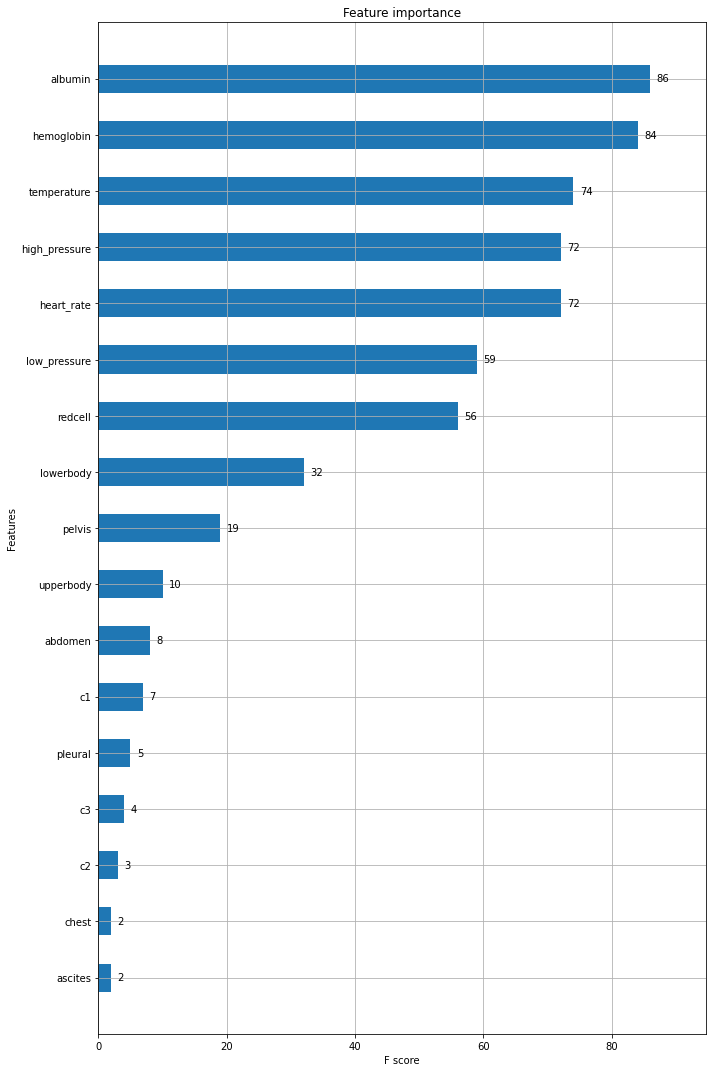

In [36]:
label_d = label.copy()
label_d[label_d > 0] = 1
dtrain = DMatrix(data=data, label=label_d, feature_names=nNullData.loc[:, 'heart_rate':'c3'].columns, silent=True)

param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 9

model = xgboost.train(param, dtrain)

fig, ax = plt.subplots(figsize=(10, 15))
# 解决中文和负号显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 使显示图标自适应
plt.rcParams['figure.autolayout'] = True
plot_importance(model, height=0.5, max_num_features=64, ax=ax)
plt.show()

# 使用决策树

In [92]:
from sklearn import tree

In [93]:
from IPython.display import Image  
import pydotplus

In [94]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(train_data, train_label)
with open("iris.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

In [95]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=nNullData.columns[1:-1],  
                         class_names=nNullData.columns[-1],  
                         filled=True, rounded=True,  
                         special_characters=True)

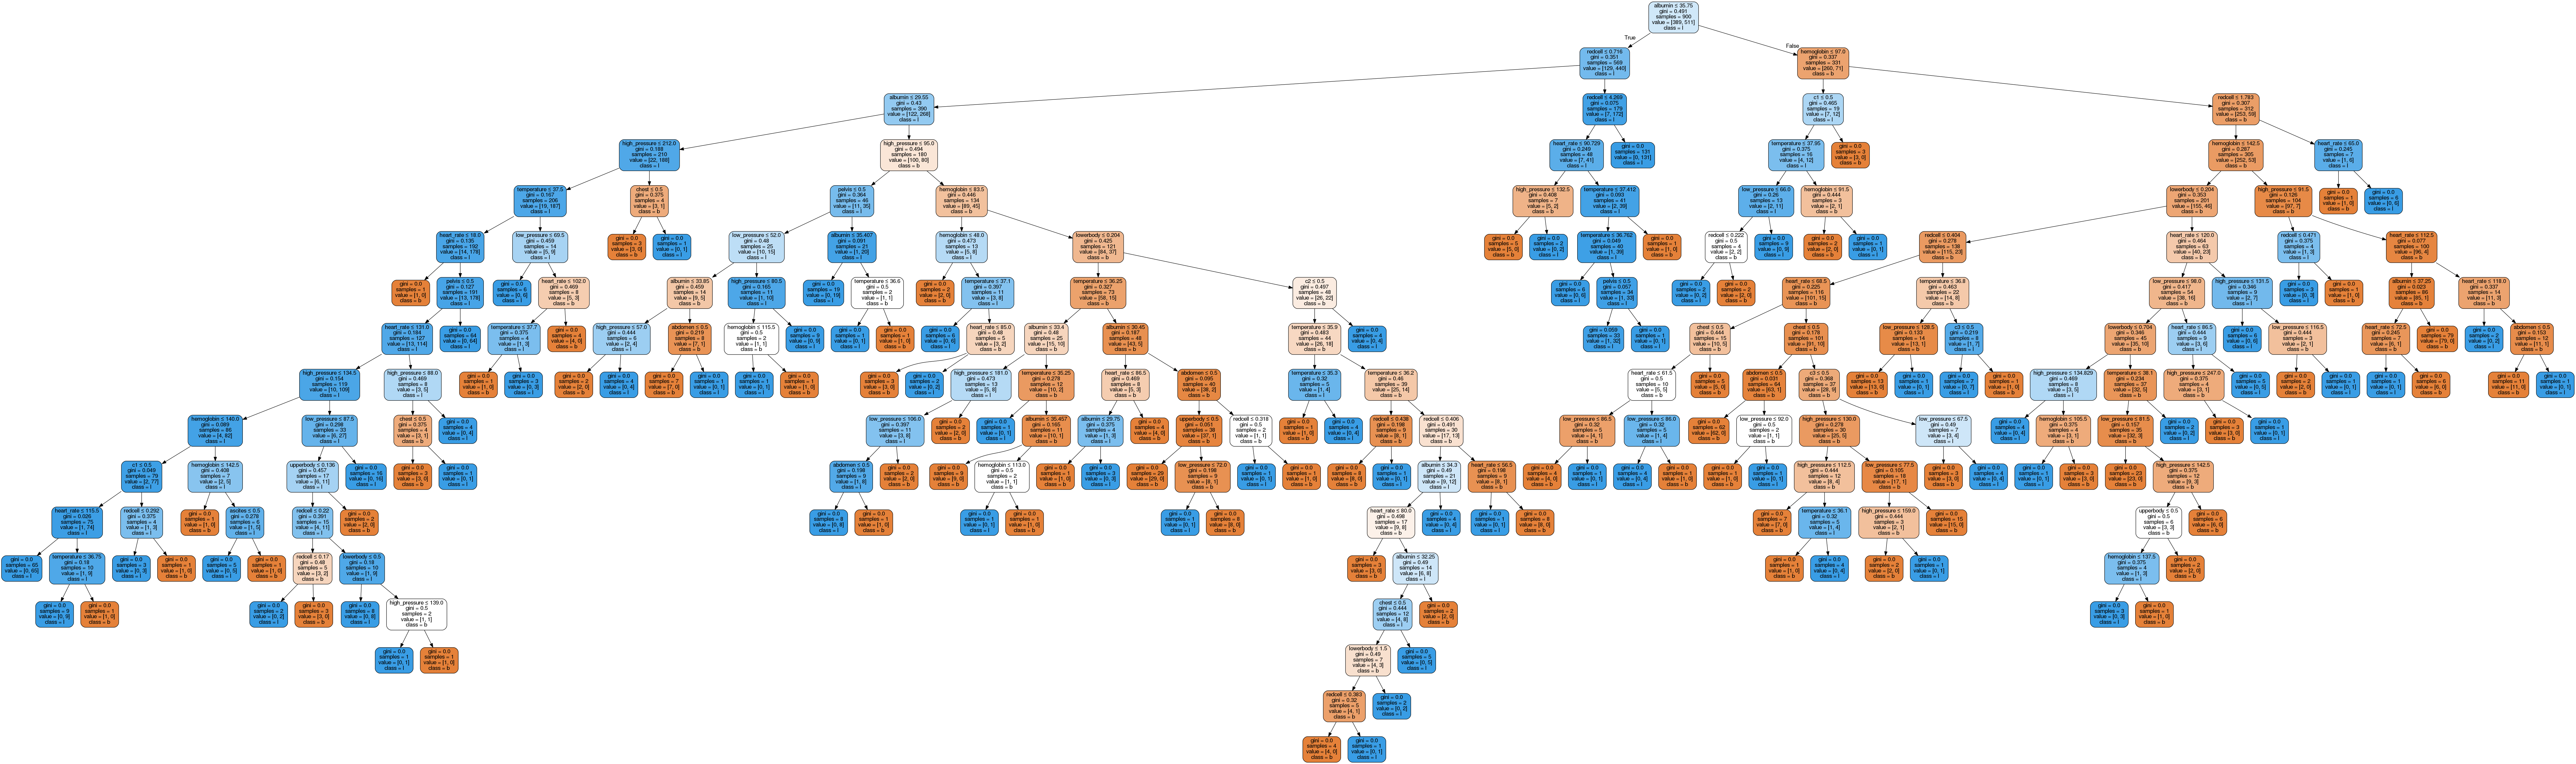

In [96]:
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [97]:
dot_data = tree.export_graphviz(clf, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("blood.pdf")

True

In [98]:
predict_label = clf.predict(test_data)
accuracy_score(predict_label, test_label)

0.6177777777777778

# 使用AutoEncoder

In [8]:
import torch 
from torch import nn, optim, tensor

In [24]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(18, 12),
                                    nn.Linear(12, 8),
                                    nn.Linear(8, 4))
        self.decoder = nn.Sequential(nn.Linear(4, 8),
                                    nn.Linear(8, 12),
                                    nn.Linear(12, 18))
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

torch.cuda.empty_cache()
model = AE()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if torch.cuda.is_available():
    tData = tensor(train_data).cuda().float()
    tLabel = tensor(train_label).cuda().long()
    tModel = model.cuda()

In [22]:
batchsize  = 900
lr = 1e-3
weight_decay = 1e-5
epoches = 1000

In [26]:
for epoch in range(epoches):
    if epoch in [epoches * 0.25, epoches * 0.5]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
    _, output = model(tData.float())
    loss = criterion(tData, output)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     for param_group in optimizer.param_groups:
#         print(param_group['lr'])
    if (epoch + 1) % 100 == 0:
        print("epoch: {}, loss is {}".format((epoch+1), loss.data))

epoch: 100, loss is 0.0376330204308033
epoch: 200, loss is 0.03763266280293465
epoch: 300, loss is 0.03763193264603615
epoch: 400, loss is 0.0376310795545578
epoch: 500, loss is 0.03763047233223915
epoch: 600, loss is 0.03763015940785408
epoch: 700, loss is 0.03762916103005409
epoch: 800, loss is 0.03762891888618469
epoch: 900, loss is 0.03762877359986305
epoch: 1000, loss is 0.037628769874572754
epoch: 1100, loss is 0.03762848675251007
epoch: 1200, loss is 0.0376288965344429
epoch: 1300, loss is 0.037628114223480225
epoch: 1400, loss is 0.0376284085214138
epoch: 1500, loss is 0.03762814402580261
epoch: 1600, loss is 0.0376279391348362
epoch: 1700, loss is 0.037628065794706345
epoch: 1800, loss is 0.037627968937158585
epoch: 1900, loss is 0.037628136575222015
epoch: 2000, loss is 0.03762798383831978
epoch: 2100, loss is 0.03762850910425186
epoch: 2200, loss is 0.03762849420309067
epoch: 2300, loss is 0.03762827813625336
epoch: 2400, loss is 0.037628065794706345
epoch: 2500, loss is 0.0

In [27]:
torch.save(model.state_dict(), 'AE2.pth')

In [33]:
test_data_dev = tensor(test_data).cuda()
test_label_dev = tensor(test_label).cuda()
_, output = model(test_data_dev.float())
loss = criterion(test_data_dev, output)
print("test loss: ", loss.data)

In [65]:
torch.save(tensor(data), 'data.pth')
torch.save(tensor(label), 'label.pth')

# sklean传统分类方法

In [4]:
from sklearn import tree, svm, naive_bayes, neighbors, linear_model, metrics
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

In [5]:
clfs = {'KNN': neighbors.KNeighborsClassifier(n_neighbors=3),\
        'LR': linear_model.LogisticRegression(penalty='l2'),\
        'random_forest' : RandomForestClassifier(n_estimators=50),\
        'decision_tree':tree.DecisionTreeClassifier(),
        'svm': svm.SVC(),\
        'gradient_boost': GradientBoostingClassifier(n_estimators=50, learning_rate=1.0,max_depth=1, random_state=0),\
        'adaboost': AdaBoostClassifier(n_estimators=50),\
        'lightGBM': lgb.LGBMClassifier(),\
        'xgboost': XGBClassifier(verbosity=0)
        
#         'naive_gaussian': naive_bayes.GaussianNB(), \
#         'naive_mul':naive_bayes.MultinomialNB(),\
#         'bagging_knn' : BaggingClassifier(neighbors.KNeighborsClassifier(), max_samples=0.5,max_features=0.5), \
#         'bagging_tree': BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=0.5,max_features=0.5),
        }

In [36]:
label[label > 0] = 1

def try_different_method(clf, train_data, train_label, test_data, test_label):
    clf.fit(train_data, train_label)
    score = clf.score(test_data, test_label)
    fpr, tpr, thresholds = metrics.roc_curve(test_label, clf.predict(test_data))
    auc = metrics.auc(fpr, tpr)
        
#     print('the score is :', score, '; auc is: ', auc)
    return score, fpr, tpr, auc

kf = KFold(n_splits=10)
acc, fprs, tprs, auc = {}, {}, {}, {}
for clf_key in clfs.keys():
    print('the classifier is :',clf_key)
    acc[clf_key], fprs[clf_key], tprs[clf_key], auc[clf_key] = [], [], [], []
    for k, (train_index, test_index) in enumerate(kf.split(data)):
        train_X, train_y = data[train_index], label[train_index]
        test_X, test_y = data[test_index], label[test_index]
        ac, fpr, tpr, au = try_different_method(clfs[clf_key], train_X, train_y, test_X, test_y)
        
        acc[clf_key].append(ac)
        auc[clf_key].append(au)
        if not np.isnan(au):
            fprs[clf_key].append(fpr)
            tprs[clf_key].append(tpr)

for (k1, v1), (k2, v2) in zip(acc.items(), auc.items()):
    print("{}, acc mean: {}, acc_val: {}, auc: {}".format(k1, np.mean(v1), np.std(v1), np.mean(v2)))

the classifier is : KNN
0.4742268041237113 [nan nan nan] [0.        0.4742268 1.       ] nan
the classifier is : LR
0.6804123711340206 [nan nan nan] [0.         0.68041237 1.        ] nan


/root/anaconda3/envs/blood/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/root/anaconda3/envs/blood/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


the classifier is : random_forest


/root/anaconda3/envs/blood/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


0.845360824742268 [nan nan nan] [0.         0.84536082 1.        ] nan
the classifier is : decision_tree
0.6804123711340206 [nan nan nan] [0.         0.68041237 1.        ] nan
the classifier is : svm
0.6288659793814433 [nan nan nan] [0.         0.62886598 1.        ] nan


/root/anaconda3/envs/blood/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/root/anaconda3/envs/blood/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


the classifier is : gradient_boost
0.7525773195876289 [nan nan nan] [0.         0.75257732 1.        ] nan


/root/anaconda3/envs/blood/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


the classifier is : adaboost


/root/anaconda3/envs/blood/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


0.7422680412371134 [nan nan nan] [0.         0.74226804 1.        ] nan
the classifier is : lightGBM


/root/anaconda3/envs/blood/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:941: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


0.7835051546391752 [nan nan nan] [0.         0.78350515 1.        ] nan
the classifier is : xgboost


/root/anaconda3/envs/blood/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/root/anaconda3/envs/blood/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/root/anaconda3/envs/blood/lib/python3.8/site-packages/xgboost/sklearn

0.7835051546391752 [nan nan nan] [0.         0.78350515 1.        ] nan


/root/anaconda3/envs/blood/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/root/anaconda3/envs/blood/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/root/anaconda3/envs/blood/lib/python3.8/site-packages/xgboost/sklearn

KNN, acc mean: 0.6715528350515465, acc_val: 0.10100108630109302, auc: nan
LR, acc mean: 0.7686211340206186, acc_val: 0.0836023689967608, auc: nan
random_forest, acc mean: 0.7799506013745704, acc_val: 0.07507886449993786, auc: nan
decision_tree, acc mean: 0.6767182130584193, acc_val: 0.029259767195497565, auc: nan
svm, acc mean: 0.7459192439862543, acc_val: 0.0827487845668539, auc: nan
gradient_boost, acc mean: 0.7468964776632302, acc_val: 0.08593672351958571, auc: nan
adaboost, acc mean: 0.7624355670103092, acc_val: 0.0702521494617172, auc: nan
lightGBM, acc mean: 0.7716709621993127, acc_val: 0.0634025893367361, auc: nan
xgboost, acc mean: 0.768567439862543, acc_val: 0.043930523098460364, auc: nan


/root/anaconda3/envs/blood/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


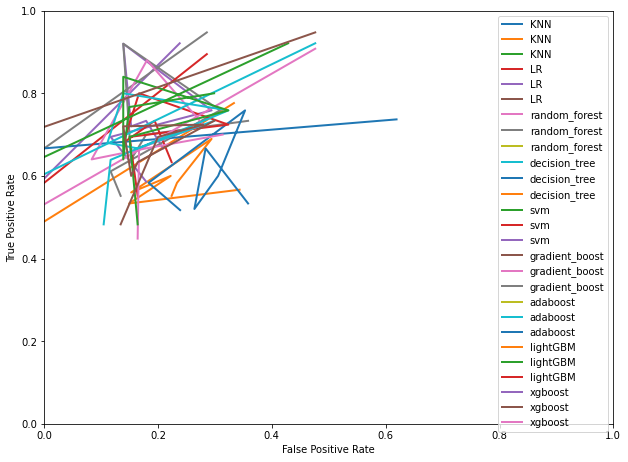

In [37]:
plt.figure(figsize=(10.2, 7.6))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
for clf_key in clfs.keys():
    plt.plot(fprs[clf_key], tprs[clf_key], lw=2, label = clf_key)
plt.legend()
plt.show()

# sklean传统回归方法

In [153]:
from sklearn import tree, svm, naive_bayes, neighbors, linear_model, metrics
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBClassifier, DMatrix, plot_importance
import lightgbm as lgb

In [186]:
refs = {'KNN': neighbors.KNeighborsRegressor(n_neighbors=3),\
        'Logistic': linear_model.LogisticRegression(penalty='l2'),\
        'LR': linear_model.LinearRegression(),\
        'random_forest' : RandomForestRegressor(n_estimators=50),\
        'decision_tree':tree.DecisionTreeRegressor(),\
        'extra_tree':tree.ExtraTreeRegressor(),\
        'svm': svm.SVR(),\
        'gradient_boost': GradientBoostingRegressor(n_estimators=50, learning_rate=1.0,max_depth=1, random_state=0),\
        'adaboost': AdaBoostRegressor(n_estimators=50),\
        'lightGBM': lgb.LGBMClassifier(),\
        'xgboost': XGBClassifier(verbosity=0),\
        'bagging': BaggingRegressor(verbose=0)
        
#         'naive_gaussian': naive_bayes.GaussianNB(), \
#         'naive_mul':naive_bayes.MultinomialNB(),\
#         'bagging_knn' : BaggingClassifier(neighbors.KNeighborsClassifier(), max_samples=0.5,max_features=0.5), \
#         'bagging_tree': BaggingClassifier(tree.DecisionTreeClassifier(), max_samples=0.5,max_features=0.5),
        }

In [188]:
def try_different_method(clf, train_data, train_label, test_data, test_label):
    clf.fit(train_data, train_label)
#     score = clf.score(test_data, test_label)
    pre_result = clf.predict(test_data)
    pre_result[pre_result < 0] = 0
    score = mean_squared_error(pre_result, test_label)
#     fpr, tpr, thresholds = metrics.roc_curve(clf.predict(test_data), test_label)
#     auc = metrics.auc(fpr, tpr)
#     print('the score is :', score, '; auc is: ', auc)
    return score

kf = KFold(n_splits=10)
acc = {}
for clf_key in clfs.keys():
    print('the classifier is :',clf_key)
    acc[clf_key] = []
    for train_index, test_index in kf.split(data):
        train_X, train_y = data[train_index], label[train_index]
        test_X, test_y = data[test_index], label[test_index]
        ac = try_different_method(refs[clf_key], train_X, train_y, test_X, test_y)
        acc[clf_key].append(ac)

for k1, v1 in acc.items():
    print("{}, acc mean: {}, acc_val: {}".format(k1, np.mean(v1), np.std(v1)))

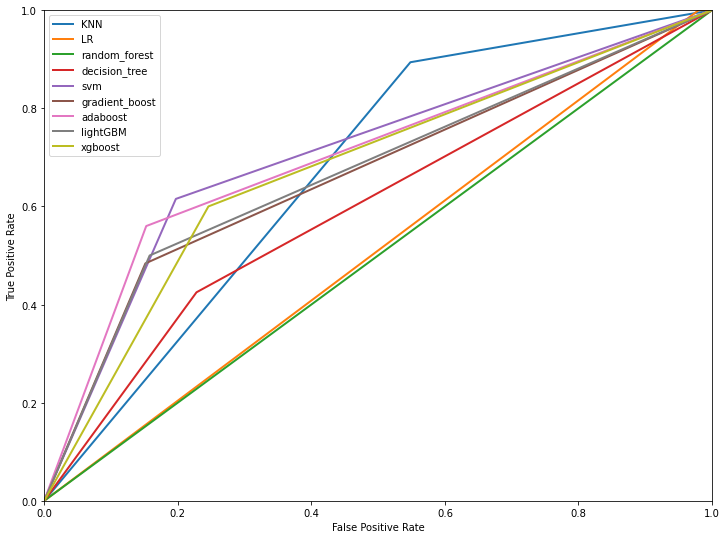

In [55]:
plt.figure(figsize=(10.2, 7.6))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
for (clf_key, fpr, tpr) in zip(clfs.keys(), fprs, tprs):
    plt.plot(fpr, tpr, lw=2, label = clf_key)
plt.legend()
plt.show()

In [190]:
data

array([[0.32843137, 0.44086022, 0.1226087 , ..., 0.        , 0.        ,
        0.        ],
       [0.36764706, 0.32795699, 0.09130435, ..., 0.        , 0.        ,
        0.        ],
       [0.44117647, 0.37634409, 0.08695652, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.41176471, 0.39247312, 0.1226087 , ..., 0.        , 0.        ,
        0.        ],
       [0.31862745, 0.35483871, 0.09826087, ..., 0.        , 0.        ,
        0.        ],
       [0.44117647, 0.42473118, 0.1173913 , ..., 0.        , 0.        ,
        0.        ]])